# __Classifying buildings Post Hurricane using Satellite Imagery__


## Introduction:

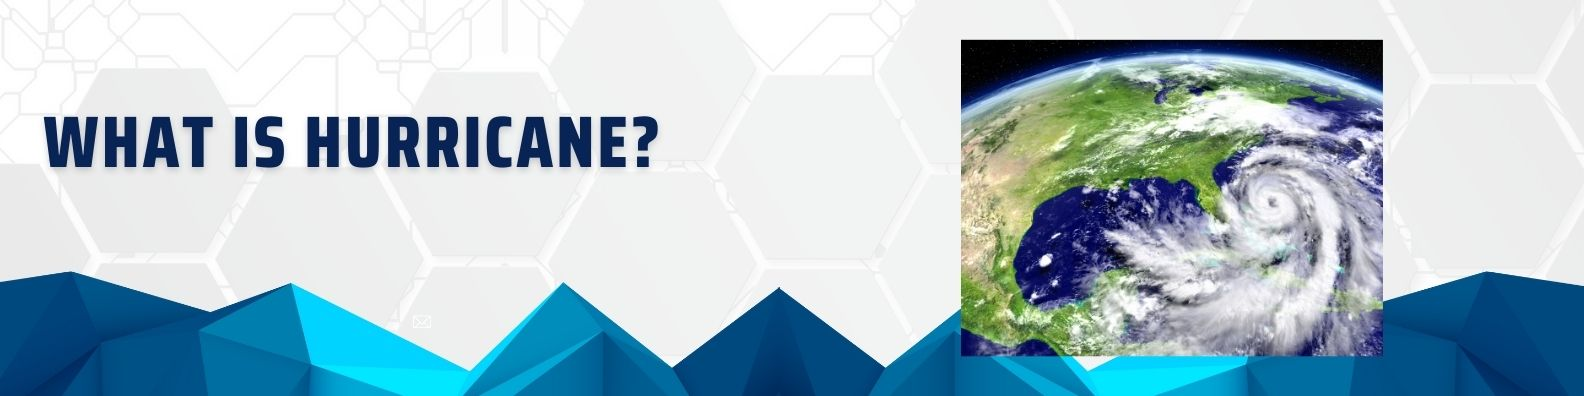

### A hurricane is a tropical storm with winds that have reached a constant speed of 74 miles per hour or more. The eye of a storm is usually 20-30 miles wide and may extend over 400 miles. The dangers of a storm include torrential rains, high winds and storm surges.

# Abstract


Damage assessment is crucial for emergency managers to respond quickly and allocate resources after a hurricane. Quantifying the number of flooded/damaged structures, which is generally done via ground survey, is one technique to measure the magnitude of the damage. This procedure can be time-consuming and labor-intensive. We create a convolutional neural network from the ground up and compare it to a widely used neural network for object classification. In a case study of building damage, we demonstrate the promise of our damage annotation approach (almost 97 percent accuracy).The data are satellite images from Texas after Hurricane Harvey divided into two groups (damage and no_damage). The goal is to make a model which can automatically identify if a given region is likely to contain flooding damage.

## Problem Statement :<br>
### To identify if the particular house is damaged or not from the Satellite Imagery provided. <br>

## Steps to take : <br>
<b>Step A</b>: Taking a look at the data and images.<br>
<b>Step B</b>: Data pre-processing.<br>
<b>Step C</b>: Building different models using CNN.<br>
<b>Step D</b>: Applying tranfer learning.<br>
<b>Step E</b>: Comaring results and conclusion.<br>

## Step A : Taking a look at the data and images :

In [ ]:
#Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')
import requests
from IPython.core.display import HTML
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import resample
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
import glob as gb
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import DenseNet121

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

In [ ]:
# Path where images are stored: 
input_path = '../input/hurricane'

### Diplaying contents of the data :

In [ ]:
# Function to see the files and size of the data:
def print_file_sizes(input_path, subset):
  print('{}:'.format(subset))
  print('')
  path = input_path + subset + '/'
  for f in os.listdir(path):
    if not os.path.isdir(path + f):
      print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
    else:
      sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
      print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
  print('')
    
print_file_sizes(input_path, '/train_another')
print_file_sizes(input_path, '/validation_another')
print_file_sizes(input_path, '/test_another')
print_file_sizes(input_path, '/test')

/train_another:

damage                        12.56MB (5000 files)
no_damage                     15.07MB (5000 files)

/validation_another:

damage                        2.52MB (1000 files)
no_damage                     3.02MB (1000 files)

/test_another:

damage                        20.12MB (8000 files)
no_damage                     3.01MB (1000 files)

/test:

damage                        2.53MB (1000 files)
no_damage                     2.99MB (1000 files)



### Taking a lok at the Images :

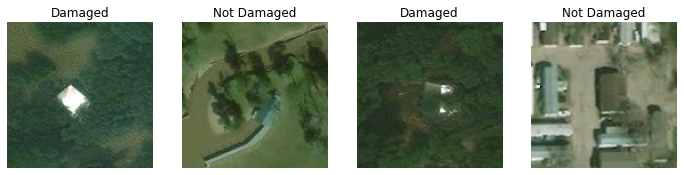

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
image1=plt.imread(input_path+'/train_another/damage/-93.55964_30.895018.jpeg')
image2=plt.imread(input_path+'/train_another/no_damage/-95.061275_29.831535.jpeg')
image3=plt.imread(input_path+'/test_another/damage/-93.528502_30.987438.jpeg')
image4=plt.imread(input_path+'/train_another/no_damage/-95.2904_29.608598999999998.jpeg')
ax[0].imshow(image1)
ax[0].set_title('Damaged')
ax[0].axis('off')
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title('Not Damaged')
ax[2].imshow(image3)
ax[2].axis('off')
ax[2].set_title('Damaged')
ax[3].imshow(image4)
ax[3].set_title('Not Damaged')
ax[3].axis('off')
plt.show()

## Step B: Data pre-processing:

In any modelling data pre-processing is the most crucial part all our resuls depends upon how well the data is processed.

In [ ]:
train_dir = input_path+'/train_another/'
test_dir = input_path+'/test/'
val_dir=input_path+'/validation_another/'
test_another_dir = input_path+'/test_another/'

Getting images in training dataset in respective classes with input image shape.

In [ ]:
size = []
for folder in  os.listdir(train_dir) : 
    files = gb.glob(pathname= str(  train_dir  + folder + '/*.jpeg'))
    print(len(files))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

5000
5000


(128, 128, 3)    10000
dtype: int64

In [ ]:
(img_width, img_height,img_channel)=size[0]
batch_size = 32
input_dim = (img_width, img_height) + (img_channel,)
classes = ['no_damage', 'damage']
code = {'no_damage':0 ,'damage':1}
code2 = {0:'no_damage' ,1:'damage'}

Data is stored into train, test, validation and extra test categories with a pre-defined batch size.

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        class_names=['no_damage', 'damage'],
      
        image_size=(img_width, img_height),
        batch_size=batch_size,
    )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        class_names=['no_damage', 'damage'],
       
        image_size=(img_width, img_height),
        batch_size=batch_size,
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        class_names=['no_damage', 'damage'],
        
        image_size=(img_width, img_height),
        batch_size=128,
    )
test_another = tf.keras.preprocessing.image_dataset_from_directory(
        test_another_dir,
        class_names=['no_damage', 'damage'],
        
        image_size=(img_width, img_height),
        batch_size=128,
    )

Found 10000 files belonging to 2 classes.


2022-04-14 13:05:59.933300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:06:00.038853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:06:00.039594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:06:00.042609: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


Simple Data augmentation is done to bring more varieties to the input dataset without altering the real data too much. Here flipping is done and brightness vales in images are changed as augmentation steps.

In [ ]:
train_data= (train_data.map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, 0.2), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

## Step C: Building different models using CNN.

### Trying simple cnn model:

In [ ]:
model_name = "Vanilla CNN"
l_r = 0.001
epochs=15

model_vanilla = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_vanilla.summary())

model_vanilla.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_vanilla = model_vanilla.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

2022-04-14 13:06:05.190360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-14 13:06:12.188327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 20s 23ms/step - loss: 0.4996 - accuracy: 0.7083 - val_loss: 0.2383 - val_accuracy: 0.9090
Epoch 2/15
313/313 [==============================] - 11s 15ms/step - loss: 0.1986 - accuracy: 0.9198 - val_loss: 0.1664 - val_accuracy: 0.9325
Epoch 3/15
313/313 [==============================] - 12s 17ms/step - loss: 0.1711 - accuracy: 0.9310 - val_loss: 0.1918 - val_accuracy: 0.9295
Epoch 4/15
313/313 [==============================] - 12s 15ms/step - loss: 0.1411 - accuracy: 0.9438 - val_loss: 0.1466 - val_accuracy: 0.9405
Epoch 5/15
313/313 [==============================] - 12s 15ms/step - loss: 0.1390 - accuracy: 0.9443 - val_loss: 0.1193 - val_accuracy: 0.9515
Epoch 6/15
313/313 [==============================] - 11s 15ms/step - loss: 0.1220 - accuracy: 0.9499 - val_loss: 0.1301 - val_accuracy: 0.9475
Epoch 7/15
313/313 [==============================] - 11s 15ms/step - loss: 0.1080 - accuracy: 0.9588 - val_loss: 0.1151 - val_accuracy: 0.9550
Epo

Evaluating Model performance on balanced and unbalanced test data.

In [ ]:
model_vanilla.evaluate(test_data)
model_vanilla.evaluate(test_another)

71/71 [==============================] - 23s 287ms/step - loss: 0.1301 - accuracy: 0.9531


[0.13006003201007843, 0.9531111121177673]

Checking Train and Validation accuracy and losses.

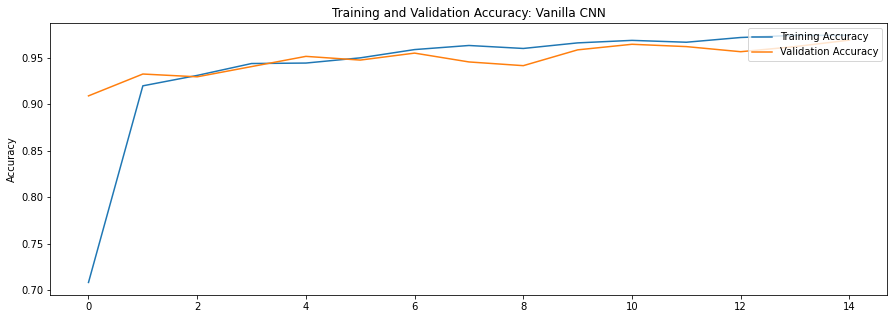

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(history_vanilla.history['accuracy'], label='Training Accuracy')
plt.plot(history_vanilla.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy: Vanilla CNN')
plt.show()

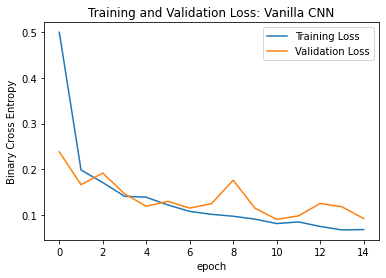

In [ ]:
plt.plot(history_vanilla.history['loss'], label='Training Loss')
plt.plot(history_vanilla.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss: Vanilla CNN')
plt.xlabel('epoch')
plt.show()

Prediction on test data and generating Classification Report and Confusion Matrix.

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model_vanilla.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.99      0.96      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix
     0    1
0  989   11
1   36  964


### Using normalization techniques:

#### Using Batch Normalization and dropout:

Regularization methods (BatchNormalization and Dropout) is implemented to enhace model efficiency.

In [ ]:
model_name = "cnn batch drop"
l_r = 0.001
epochs=15

model_reg1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  
    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Dropout(0.30),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_reg1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)       

In [ ]:
#compile the model 
model_reg1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model_reg1.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
)

Epoch 1/15
313/313 [==============================] - 21s 41ms/step - loss: 1.2581 - accuracy: 0.8588 - val_loss: 1.9270 - val_accuracy: 0.5000
Epoch 2/15
313/313 [==============================] - 18s 39ms/step - loss: 0.1731 - accuracy: 0.9322 - val_loss: 0.5979 - val_accuracy: 0.7785
Epoch 3/15
313/313 [==============================] - 18s 38ms/step - loss: 0.1315 - accuracy: 0.9499 - val_loss: 1.1056 - val_accuracy: 0.7385
Epoch 4/15
313/313 [==============================] - 18s 38ms/step - loss: 0.1137 - accuracy: 0.9564 - val_loss: 0.6156 - val_accuracy: 0.8140
Epoch 5/15
313/313 [==============================] - 18s 38ms/step - loss: 0.1054 - accuracy: 0.9568 - val_loss: 0.2012 - val_accuracy: 0.9200
Epoch 6/15
313/313 [==============================] - 18s 39ms/step - loss: 0.1011 - accuracy: 0.9609 - val_loss: 0.8693 - val_accuracy: 0.7295
Epoch 7/15
313/313 [==============================] - 18s 39ms/step - loss: 0.0962 - accuracy: 0.9622 - val_loss: 0.9203 - val_accuracy:

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7faa128cb560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 9/15
313/313 [==============================] - 18s 38ms/step - loss: 0.0711 - accuracy: 0.9725 - val_loss: 0.0963 - val_accuracy: 0.9600
Epoch 10/15
313/313 [==============================] - 19s 39ms/step - loss: 0.0643 - accuracy: 0.9758 - val_loss: 1.2763 - val_accuracy: 0.6530
Epoch 11/15
313/313 [==============================] - 18s 39ms/step - loss: 0.0621 - accuracy: 0.9755 - val_loss: 0.3936 - val_accuracy: 0.8995
Epoch 12/15
313/313 [==============================] - 18s 38ms/step - loss: 0.0577 - accuracy: 0.9785 - val_loss: 0.2959 - val_accuracy: 0.9375
Epoch 13/15
313/313 [==============================] - 18s 38ms/step - loss: 0.0498 - accuracy: 0.9824 - val_loss: 0.3367 - val_accuracy: 0.8870
Epoch 14/15
313/313 [==============================] - 17s 38ms/step - loss: 0.0629 - accuracy: 0.9767 - val_loss: 1.0567 - val_accuracy: 0.6785
Epoch 15/15
313/313 [==============================] - 18s 38ms/step - loss: 0.0565 - accuracy: 0.9778 - val_loss: 0.3985 - val_acc

Evaluating model performance on test data's.

In [ ]:
model_reg1.evaluate(test_data)
model_reg1.evaluate(test_another)

71/71 [==============================] - 5s 70ms/step - loss: 0.4227 - accuracy: 0.7926


[0.42270326614379883, 0.792555570602417]

Predicting values on test dataset and checking evaluating metrics.

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_reg1.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1000
           1       0.86      0.80      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000


Confusion Matrix
     0    1
0  874  126
1  198  802


#### Applying Early Stopping:

To avoid overfitting and to avoid unnecessary training of data if there is no significant improvement in metrics.

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True
                                     )

In [ ]:
model_name = "Early Stopping"
l_r = 0.001
epochs=15

model_es = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_es.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_es = model_es.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

Here, training stopped at 11th epoch.

In [ ]:
model_es.evaluate(test_data)
model_es.evaluate(test_another)

71/71 [==============================] - 5s 63ms/step - loss: 0.1117 - accuracy: 0.9600


[0.11165628582239151, 0.9599999785423279]

Predicting over test data and creating Classification Report and Confusion Matrix.

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_es.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1000
           1       0.95      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000


Confusion Matrix
     0    1
0  951   49
1   38  962


_So far Our best performing model is "vanilla_cnn" without batch Normalization and dropout: The classification matrices calculated are satisfactory._

### Comparing different metrics (using various loss functions, activations):

**Activation Function:**

Activation functions helps our model to calculate complex patterens of data cnn provides different activation functions we are trying some of them below.

In [ ]:

l_r = 0.001
epochs=15

model_1b = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='elu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='elu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='elu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='elu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='elu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='elu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='elu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_1b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_1b = model_1b.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

In [ ]:
model_1b.evaluate(test_data)
model_1b.evaluate(test_another)

71/71 [==============================] - 5s 61ms/step - loss: 0.1847 - accuracy: 0.9237


[0.18467143177986145, 0.9236666560173035]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_1b.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:01<00:00,  8.12it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1000
           1       0.91      0.92      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000


Confusion Matrix
     0    1
0  910   90
1   83  917


In [ ]:

l_r = 0.001
epochs=15

model_1c = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='selu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='selu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='selu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='selu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='selu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='selu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='selu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_1c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_1c = model_1c.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

In [ ]:
model_1c.evaluate(test_data)
model_1c.evaluate(test_another)

71/71 [==============================] - 4s 55ms/step - loss: 0.1560 - accuracy: 0.9379


[0.155997171998024, 0.9378888607025146]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_1c.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))


Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  7.59it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1000
           1       0.98      0.94      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000


Confusion Matrix
     0    1
0  984   16
1   63  937


**Inference:**From vanilla CNN model and models 1b and 1c, 
the activation function suited for the task is 'relu'.

**Loss Functions:**

In [ ]:

l_r = 0.001
epochs=15

model_2b = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_2b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history_2b = model_2b.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

In [ ]:
model_2b.evaluate(test_data)
model_2b.evaluate(test_another)

71/71 [==============================] - 5s 65ms/step - loss: 0.0000e+00 - accuracy: 0.1111


[0.0, 0.1111111119389534]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_2b.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))


Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  7.36it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1000
           1       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000


Confusion Matrix
      0  1
0  1000  0
1  1000  0


Note: As expected tf.keras.losses.CategoricalCrossentropy() is not meant for binary classification.

In [ ]:

l_r = 0.001
epochs=15

model_2c = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_2c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_2c = model_2c.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

In [ ]:
model_2c.evaluate(test_data)
model_2c.evaluate(test_another)

71/71 [==============================] - 4s 54ms/step - loss: nan - accuracy: 0.1111


[nan, 0.1111111119389534]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_2c.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1000
           1       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000


Confusion Matrix
      0  1
0  1000  0
1  1000  0


**Inference:** From vanilla CNN model and model 2b and 2c, the ideal loss function is Binary cross entropy.

**Optimizer**

In [ ]:

l_r = 0.001
epochs=15

model_3b = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_es.summary())

model_3b.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_3b = model_3b.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

In [ ]:
model_3b.evaluate(test_data)
model_3b.evaluate(test_another)

71/71 [==============================] - 5s 60ms/step - loss: 0.1387 - accuracy: 0.9590


[0.1386515349149704, 0.9589999914169312]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_3b.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  7.47it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1000
           1       0.94      0.95      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


Confusion Matrix
     0    1
0  938   62
1   45  955


In [ ]:

l_r = 0.001
epochs=15

model_3c = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_dim),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
 
    
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),

    
  layers.Conv2D(128, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


print(model_3c.summary())

model_3c.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_3c = model_3c.fit(
  train_data,
  validation_data=val_data,
     callbacks=[es],
  epochs=epochs,
)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 16, 16, 64)      

In [ ]:
model_3c.evaluate(test_data)
model_3c.evaluate(test_another)

71/71 [==============================] - 5s 62ms/step - loss: 0.2010 - accuracy: 0.9266


[0.20097310841083527, 0.9265555739402771]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_3c.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1000
           1       0.87      0.92      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000


Confusion Matrix
     0    1
0  859  141
1   80  920


**Inference:** From vanilla CNN and model 3b and 3c results, Adam optimizer performs better than others.

**Best Model**

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model_vanilla.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.99      0.96      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix
     0    1
0  989   11
1   36  964


In [ ]:
fpr, tpr, thresholds_keras = roc_curve(test_labels1, predictions)
auc_val = auc(fpr, tpr)
auc_val

0.997154

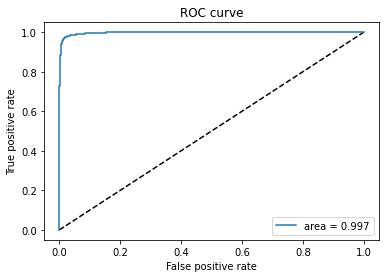

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Inference:** Even in the ROC plot and AUC value, base model performace is on the higher side.

In [ ]:
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze() + 0.5)

    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='gray')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',size=16,y=1.05);'/'

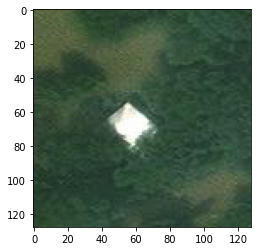

In [ ]:
img_path = '../input/hurricane/train_another/damage/-93.55964_30.895018.jpeg'
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size = (128,128))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

Checking feature maps out of each convolution layers from the CNN model.

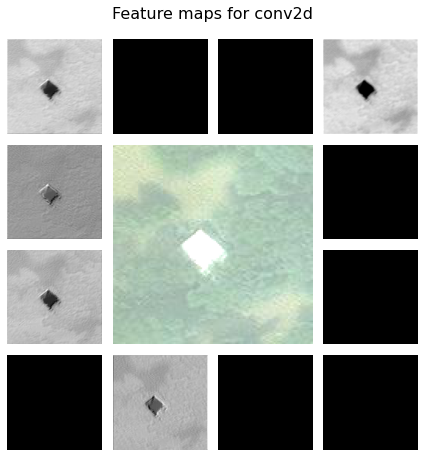

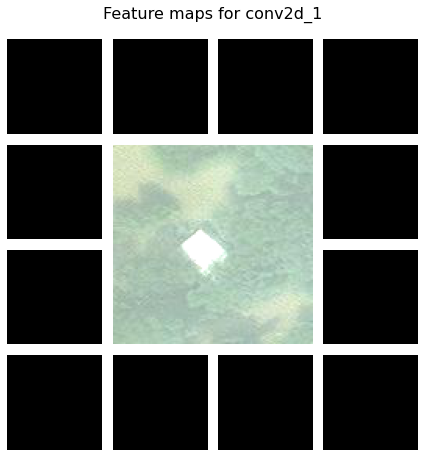

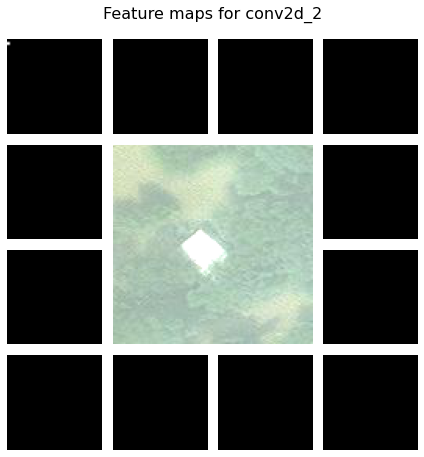

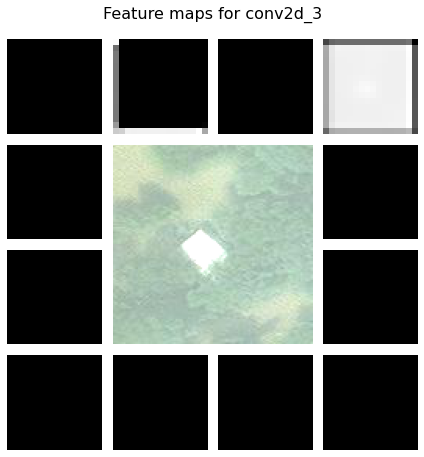

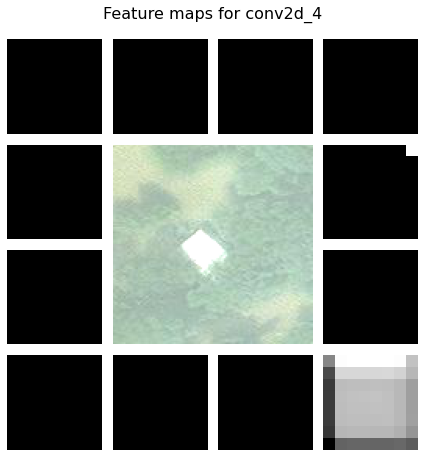

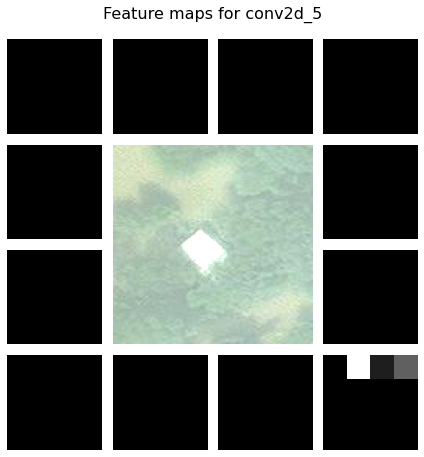

In [ ]:
l=[1,3,5,7,9,11]
for i in l:
    layer_op = model_vanilla.layers[i].output
    act_model = tf.keras.Model(model_vanilla.input,layer_op)
    acts = act_model.predict(img_tensor)
    plot_featuremaps(img_tensor,acts,[model_vanilla.layers[i].name])

## Step D: Applying tranfer learning.

### ResNet50:

In [ ]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(128,128,3), pooling='max')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_res=Sequential()
model_res.add(base_model)
model_res.add(Dropout(0.20))
model_res.add(Dense(2048,activation='relu'))
model_res.add(Dense(1024,activation='relu'))
model_res.add(Dense(512,activation='relu'))
model_res.add(Dense(1,activation='sigmoid'))
model_res.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_42 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 513       
Total params: 30,407,553
Trainable params: 30,354,433
Non-trainable params: 53,120
____________________________________

In [ ]:
epochs=15
batch_size=32
model_res.compile(optimizer=Adam(lr=1e-3),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
history_res = model_res.fit(
  train_data,
  validation_data=val_data,
  callbacks=[es], 
  epochs=epochs,
  
)

Epoch 1/15
313/313 [==============================] - 37s 84ms/step - loss: 0.4258 - accuracy: 0.9173 - val_loss: 0.4586 - val_accuracy: 0.7820
Epoch 2/15
313/313 [==============================] - 31s 80ms/step - loss: 0.2570 - accuracy: 0.9199 - val_loss: 0.4258 - val_accuracy: 0.8225
Epoch 3/15
313/313 [==============================] - 31s 81ms/step - loss: 0.1248 - accuracy: 0.9541 - val_loss: 3.8200 - val_accuracy: 0.6385
Epoch 4/15
313/313 [==============================] - 31s 81ms/step - loss: 0.1076 - accuracy: 0.9598 - val_loss: 1.8718 - val_accuracy: 0.5440


In [ ]:
model_res.evaluate(test_data)
model_res.evaluate(test_another)

71/71 [==============================] - 6s 85ms/step - loss: 0.7412 - accuracy: 0.1136


[0.7412059903144836, 0.11355555802583694]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_res.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1000
           1       1.00      0.00      0.01      1000

    accuracy                           0.50      2000
   macro avg       0.75      0.50      0.34      2000
weighted avg       0.75      0.50      0.34      2000


Confusion Matrix
      0  1
0  1000  0
1   997  3


**DenseNet**

In [ ]:
base_model_DenseNet=DenseNet121(include_top=False, weights='imagenet',input_shape=(128,128,3), pooling='max')
model_DenseNet=Sequential()
model_DenseNet.add(base_model_DenseNet)
model_DenseNet.add(Dropout(0.20))
model_DenseNet.add(Dense(2048,activation='relu'))
model_DenseNet.add(Dense(1024,activation='relu'))
model_DenseNet.add(Dense(512,activation='relu'))
model_DenseNet.add(Dense(1,activation='sigmoid'))
model_DenseNet.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_49 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_50 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 513       
Total params: 11,760,193
Trainable params: 11,676,545
Non-trainable params: 83,648
____________________________________

In [ ]:
epochs=15
batch_size=32
model_DenseNet.compile(optimizer=Adam(lr=1e-3),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

history_dense = model_DenseNet.fit(
  train_data,
  validation_data=val_data,
  callbacks=[es], 
  epochs=epochs,
  
)

Epoch 1/15
313/313 [==============================] - 47s 97ms/step - loss: 0.2474 - accuracy: 0.9219 - val_loss: 0.1458 - val_accuracy: 0.9450
Epoch 2/15
313/313 [==============================] - 35s 91ms/step - loss: 0.1008 - accuracy: 0.9629 - val_loss: 0.4824 - val_accuracy: 0.7725
Epoch 3/15
313/313 [==============================] - 36s 95ms/step - loss: 0.0771 - accuracy: 0.9720 - val_loss: 2.8300 - val_accuracy: 0.5750


In [ ]:
model_DenseNet.evaluate(test_data)
model_DenseNet.evaluate(test_another)

71/71 [==============================] - 7s 87ms/step - loss: 0.1091 - accuracy: 0.9423


[0.10907287150621414, 0.9423333406448364]

In [ ]:
test_labels = []
predictions = []

for imgs, labels in tqdm(test_data.take(1000), 
                             desc='Predicting on Test Data'):
        batch_preds = model_DenseNet.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

predictions = np.array(predictions)
predictions = predictions.ravel()
test_labels1 = np.array(test_labels)
predictions1 = np.where(predictions > 0.5, 1, 0)

cm1 = confusion_matrix(test_labels1, predictions1)

print("Classification Report")
print(classification_report(test_labels1, predictions1))
print()
print("Confusion Matrix")
print(pd.DataFrame(cm1))

Predicting on Test Data: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1000
           1       0.95      0.93      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000


Confusion Matrix
     0    1
0  954   46
1   66  934


**Inference:** In this scenerio, the CNN model impelmented in this notebook performs better than the state of the art models like resNet and DenseNet with lesser number of parameters making it a light weight model which can be implemented in real time applications.

## Step E: Results and conclusion.

We demonstrated that convolutional neural networks can automatically annotate flooded/damaged buildings on post-hurricane satellite imagery with high accuracy. We tried compared different activation, loss and optimizer functions to check which one suits the best and arrived at a efficient CNN model. The model even performed better than the state- of -the art models like DenseNet and ResNet. Also the lesser number of parameters makes it a light weight model which needs lesser compuatational power, and hence can be implemenetd on real time applications.

**Future Scope:** Although the current study extracts positive and negative samples from the dataset using distinct temporal information, it would be more realistic to collect samples from various spatial information using the same timestamp after the event occurs. This would bring the data closer to the real-world scenario when the method is intended to be used after a specific event occurs.